## Summary note of the phonon olympics entry for Germanium

- **Author**: Terumasa TADANO (NIMS)
- **Date**: June. 6, 2022.
- **Codes**: VASP 6.2.1 + ALAMODE 1.3.0 (some new features of dev branch are also tested)
- **Compilers**: Intel Compiler version 20.0.2.254 + Intel MKL
- **Compile flags**: `-O2` for ALAMODE, `-O2 -xHOST` for VASP
- **MPI library**: HPE MPI 2.21
- **Computer Resource**: NIMS simulator (Intel Xeon Platinum 8268 24core 2.9 GHz x 2 / node)

In [1]:
from pymatgen.io.vasp.outputs import Vasprun, Procar, Outcar

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl

import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.set_option('display.max_rows', 100)

params = {'backend': 'ps',
          'text.latex.preamble': ['\\usepackage{gensymb}'],
          'axes.labelsize': 22, # fontsize for x and y labels (was 10)
          'axes.titlesize': 10,
          'font.size': 11, # was 10
          'legend.fontsize': 6, # was 10
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': False,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial'
}

mpl.rcParams.update(params)

In [2]:
font = Font(size=14, name='Calibri')

def write_dataframe_to_excel(ws, pd, irow = 1, icol = 1, adjust_width=True):
    
    rows = dataframe_to_rows(pd, index=False, header=True)
    
    for row_no, row in enumerate(rows, irow):
        for col_no, value in enumerate(row, icol):
            ws.cell(row=row_no, column=col_no, value=value).font = font
            
    if adjust_width:
        for col in ws.columns:
            max_length = 0
            column = col[0].column

            for cell in col:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
                
            adjusted_width = (max_length + 2)
            ws.column_dimensions[get_column_letter(column)].width = adjusted_width

In [3]:
# Reference in-plane lattice constant
a0 = 3.3269482229713101

vasp_kmesh = pd.read_table('VASP/1.Structure/convergence_check/EOS_conv_check_kmesh.dat', 
                           header=None, skiprows=0, delim_whitespace=True, 
                           usecols=[0, 1, 3, 4],
                           names=('# k points along each axis', 
                                  'lattice constant (Ang.)',
                                  'energy (eV)', 
                                  'Se-Se distance (Ang.)'))

vasp_kmesh['lattice constant (Ang.)'] *= a0


vasp_encut = pd.read_table('VASP/1.Structure/convergence_check/EOS_conv_check_ENCUT.dat', 
                           header=None, skiprows=0, delim_whitespace=True, 
                           usecols=[0, 1, 3, 4],
                           names=('ENCUT (eV)',  'lattice constant (Ang.)', 
                                  'energy (eV)', 'Se-Se distance (Ang.)'))

vasp_encut['lattice constant (Ang.)'] *= a0

corehours_list = []
encut_range = np.arange(200, 1001, 50)
for encut in encut_range:
    corehours = 0.0
    
    for inplane_change in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
#        vasprun = Vasprun('VASP/1.Structure/convergence_check/vasprun_ENCUT%d.k=12.%+d.xml' % (encut, inplane_change))
        outcar = Outcar('VASP/1.Structure/convergence_check/OUTCAR.ENCUT%d.k=12.%+d' % (encut, inplane_change))
        corehours += float(outcar.run_stats['cores']) * float(outcar.run_stats['Elapsed time (sec)'])/3600

    corehours_list.append(corehours)
    
vasp_encut['Core Hours'] = corehours_list

corehours_list = []
kmesh_range = np.arange(5, 21, 1)
for kmesh in kmesh_range:
    corehours = 0.0
    
    for inplane_change in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
#        vasprun = Vasprun('VASP/1.Structure/convergence_check/vasprun_ENCUT600.k=%d.xml' % kmesh)
        outcar = Outcar('VASP/1.Structure/convergence_check/OUTCAR.ENCUT600.k=%d.%+d' % (kmesh, inplane_change))
        corehours += float(outcar.run_stats['cores']) * float(outcar.run_stats['Elapsed time (sec)'])/3600
    
    corehours_list.append(corehours)


vasp_kmesh['Core Hours'] = corehours_list



## 1. Structure - summary

The calculations were performed using `VASP` code with the following input parameters:
```
 PREC = Accurate
 ENCUT = 450
 EDIFF = 1.0e-8
 EDIFFG = -1.0e-4
 ISMEAR = 0
 SIGMA = 0.05
 ALGO= Normal
 LREAL = .FALSE.
 ADDGRID = .TRUE.
 LWAVE = .FALSE.
 LCHARG = .FALSE.
 ICHARG= 2
 ISTART=0
 NELM=200

 NPAR = 12
 ISIF = 4
 IBRION = 2
 NSW = 100
 POTIM = 0.1

 GGA = PS
 LAPSH = .True.
 ```

As shown in the tables and figures below, the lattice constant obtained from the equation-of-state fitting appears to reach convergence at 12x12x12 k points and `ENCUT=450`. So, I have chosen

- **ENCUT = 450**
- **12x12x12 k points for primitive**
- **a = 3.27 Angstrom**
- **c = 18.35 Angstrom**
- **d_{Se-Se} = 3.33 Angstrom**

for the following electronic/phonon calculations.


In [4]:
vasp_encut

,ENCUT (eV),lattice constant (Ang.),energy (eV),Se-Se distance (Ang.),Core Hours
0,200.0,3.263367,-21.302035,3.332592,2.692267
1,250.0,3.270600,-21.573823,3.331152,3.308640
2,300.0,3.270181,-21.588636,3.330525,3.794987
3,350.0,3.270074,-21.582925,3.330557,4.325120
4,400.0,3.270230,-21.584045,3.330342,4.891573
5,450.0,3.270077,-21.585465,3.330229,5.247520
6,500.0,3.270074,-21.586037,3.330194,6.251360
7,550.0,3.270084,-21.586228,3.330177,6.940533
8,600.0,3.270054,-21.586555,3.330170,7.747253
9,650.0,3.270008,-21.586735,3.330147,8.662880


In [5]:
vasp_kmesh

,# k points along each axis,lattice constant (Ang.),energy (eV),Se-Se distance (Ang.),Core Hours
0,5,3.271222,-21.583849,3.329585,5.972800
1,6,3.269911,-21.585260,3.330606,6.126667
2,7,3.270034,-21.586395,3.330231,6.003840
3,8,3.270107,-21.586227,3.330122,6.493173
4,9,3.270027,-21.586506,3.330199,6.661440
5,10,3.270074,-21.586584,3.330137,7.236907
6,11,3.270057,-21.586550,3.330166,7.219520
7,12,3.270054,-21.586555,3.330170,7.747253
8,13,3.270057,-21.586561,3.330165,8.285867
9,14,3.270054,-21.586552,3.330169,8.448693


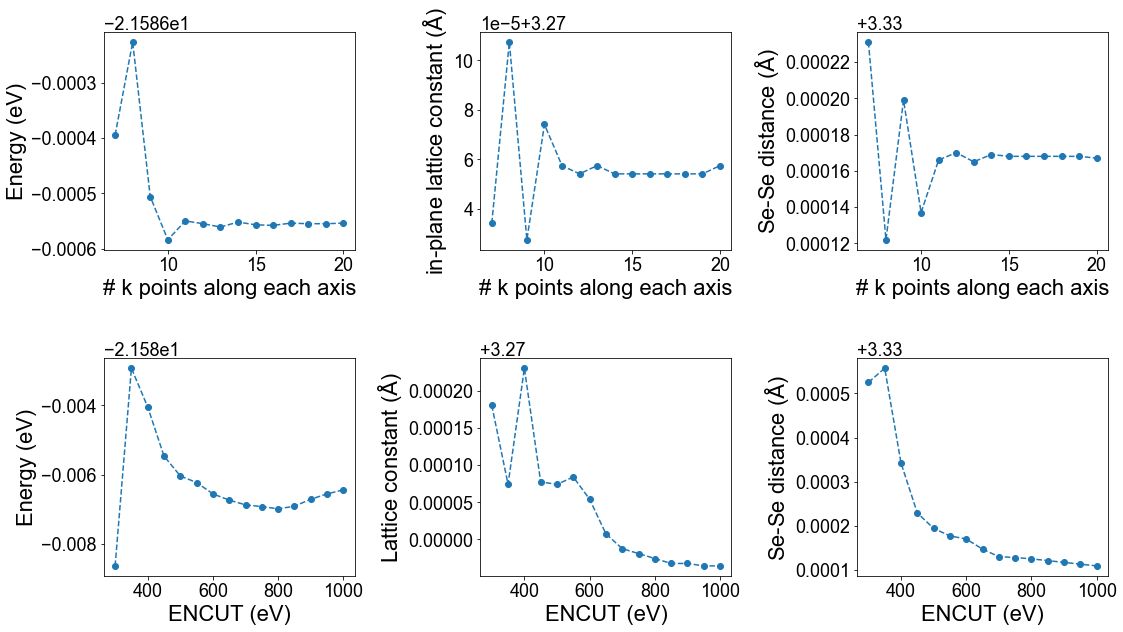

In [6]:
%matplotlib inline
# Plot figure below
fig = plt.figure(figsize=(18,10))

nrows = 2; ncols = 3
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ax = plt.subplot(gs[0,0])
vasp_kmesh[2:].plot(x=0,y=2,kind='line', ylabel='Energy (eV)', marker='o', linestyle='--', ax=ax, legend=False)
ax = plt.subplot(gs[0,1])
vasp_kmesh[2:].plot(x=0,y=1,kind='line', legend=False,
                ylabel='in-plane lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax = plt.subplot(gs[0,2])
vasp_kmesh[2:].plot(x=0,y=3,kind='line', legend=False,
                ylabel='Se-Se distance ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax = plt.subplot(gs[1,0])
vasp_encut[2:].plot(x=0,y=2,kind='line', legend=False,
                ylabel='Energy (eV)', marker='o', linestyle='--', ax=ax)
ax = plt.subplot(gs[1,1])
vasp_encut[2:].plot(x=0,y=1,kind='line', legend=False,
                ylabel='Lattice constant ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
ax = plt.subplot(gs[1,2])
vasp_encut[2:].plot(x=0,y=3,kind='line', legend=False,
                ylabel='Se-Se distance ($\mathrm{\AA}$)', marker='o', linestyle='--', ax=ax)
plt.savefig('convergence_structure.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Electronic band structure

from pymatgen.electronic_structure.core import Spin, Orbital

bs1 = []
bs2 = []

pathes = ['G-M', 'G-K-M']
nb = 11

for i in range(2):
    df = pd.DataFrame()
    
    dosrun= Vasprun("./VASP/2.Electrons/vasprun_scf.xml", parse_dos=True)
    dos = dosrun.complete_dos
    bs = Vasprun(
        "./VASP/2.Electrons/vasprun_band%d.xml" % (i+1)).get_band_structure(
        "./VASP/2.Electrons/KPOINTS.band%d" % (i+1), 
        efermi=dosrun.efermi, 
        line_mode=True)

    df.attrs['efermi'] = dos.efermi
    df.attrs['line'] = pathes[i]
    df.attrs['SCF'] = '(SCF 12x12x1 G-cntrd k points)'
    
    kval = np.array(bs.distance)
    data = bs.bands[Spin.up]
    df['k_distance (normalized)'] = kval / kval[-1]
    for ib in range(nb):
        df['E%d' % (ib+1)] = data[ib+6,:] - dos.efermi
        
    bs1.append(df)


for i in range(2):
    df = pd.DataFrame()
    
    dosrun= Vasprun("./VASP/2.Electrons/vasprun_scf_dense.xml", parse_dos=True)
    dos = dosrun.complete_dos
    bs = Vasprun(
        "./VASP/2.Electrons/vasprun_band%d_dense.xml" % (i+1)).get_band_structure(
        "./VASP/2.Electrons/KPOINTS.band%d" % (i+1), 
        efermi=dosrun.efermi, 
        line_mode=True)

    df.attrs['efermi'] = dos.efermi
    df.attrs['line'] = pathes[i]
    df.attrs['SCF'] = '(SCF 16x16x1 G-cntrd k points)'
    
    kval = np.array(bs.distance)
    data = bs.bands[Spin.up]
    df['k_distance (normalized)'] = kval / kval[-1]
    for ib in range(nb):
        df['E%d' % (ib+1)] = data[ib+6,:] - dos.efermi
        
    bs2.append(df)    

## 2. Electronic - summary
The electronic band dispersion obtained from the 12x12x1 k points agrees well with the result obtained from the denser 16x16x1 k points. So, we conclude that 12x12x1 kpoints was accurate enough.

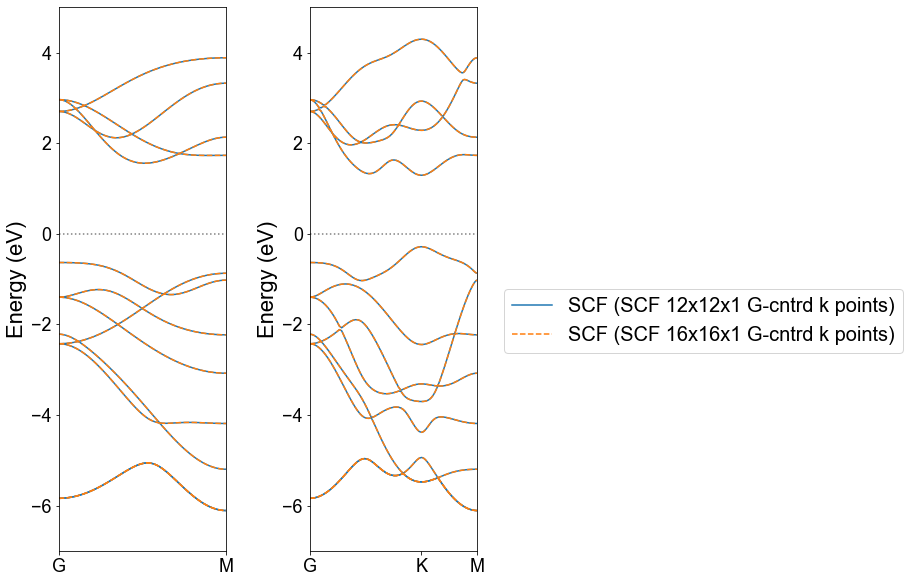

In [8]:
fig = plt.figure(figsize=(12,10))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ranges = [[0, 100], [0, 100]]
labels = [['G', 'M'], ['G', 'K', 'M']]
tickvals = [[0, 1], [0, 0.666667, 1]]


for iax, ra in enumerate(ranges):
    
    ax = plt.subplot(gs[iax])
    
    ax.plot(bs1[iax]['k_distance (normalized)'], 
            bs1[iax]['E1'], linestyle='-', 
            marker='None', color='C0', label='SCF %s' % bs1[iax].attrs['SCF'])
    
    for ib in range(1, 12):
        ax.plot(bs1[iax]['k_distance (normalized)'], 
                bs1[iax]['E%d' % ib], linestyle='-', 
                marker='None', color='C0')
        
    ax.plot(bs2[iax]['k_distance (normalized)'], 
            bs2[iax]['E1'], linestyle='--', 
            marker='None', color='C1', label='SCF %s' % bs2[iax].attrs['SCF'])
    
    for ib in range(1, 12):
        ax.plot(bs2[iax]['k_distance (normalized)'], 
                bs2[iax]['E%d' % ib], linestyle='--', 
                marker='None', color='C1')
    
    xmin = tickvals[iax][0]
    xmax = tickvals[iax][-1]
    tickvals[iax][:]= (np.array(tickvals[iax][:])-xmin)/(xmax-xmin)
    ax.set_xlim(tickvals[iax][0], tickvals[iax][-1])
    ax.set_xticklabels(labels[iax])
    ax.set_xticks(tickvals[iax])
    ax.set_ylim(-7, 5)
    ax.set_ylabel('Energy (eV)')
    ax.axhline(y=0.0, linestyle=':', color='gray')
    if iax == 1:
        ax.legend(fontsize=20, bbox_to_anchor=(1.1, 0.5))

plt.savefig('ElectronicBandStructure.pdf', dpi=300, bbox_inches='tight')        
plt.show()

In [9]:
# 3. Harmonic calculation

encut_list = np.arange(400, 801, 50)

headers = ['ENCUT (eV)', 'k mesh style', 'k mesh', 'k mesh shift', 
           'f_G1', 'f_G2', 'f_G3', 'f_G4', 
           'f_M1', 'f_M2', 'f_M3', 'f_M4', 'f_M5', 'f_M6', 'f_M7', 'f_M8', 'f_M9']

frequencies = np.loadtxt('VASP/3.Harmonic/221/convergence_check/convergence_encut.dat')

kpoint_info = []
for encut in encut_list:
    vasprun_dict = Vasprun('VASP/3.Harmonic/221/convergence_check/vasprun_disp1_ENCUT%d.xml' % encut).as_dict()['input']['kpoints']
    kpoint_info.append([vasprun_dict['generation_style'],
                        vasprun_dict['kpoints'][0],
                        vasprun_dict['shift']])


summary_ph221_convcheck = pd.read_table('VASP/3.Harmonic/221/convergence_check/convergence_encut.dat', 
                                        header=None, skiprows=1, delim_whitespace=True, 
                                        names=('ENCUT (eV)', 'f_G1', 'f_G2', 'f_G3', 'f_G4', 
                                               'f_M1', 'f_M2', 'f_M3', 'f_M4', 'f_M5', 'f_M6', 'f_M7', 'f_M8', 'f_M9'))
list_kp = list(zip(*kpoint_info))
summary_ph221_convcheck['k mesh style'] = list_kp[0]
summary_ph221_convcheck['k mesh'] = list_kp[1]
summary_ph221_convcheck['k mesh shift'] = list_kp[2]

## 3.1 Harmonic - convergence at G and M points

The phonon frequencies at Gamma (0,0,0) and M(0.5, 0.0, 0.0) points are calculated using the following conditions:

- 2x2x1 supercell (12 atoms)
- displacement magnitude : 0.01 Angstrom
- make full use of symmetry (permutation, space group)
- consider ASR as constraint
- Fit displacement-force dataset by ordinary least squares

In [10]:
summary_ph221_convcheck

,ENCUT (eV),f_G1,f_G2,f_G3,f_G4,f_M1,f_M2,f_M3,f_M4,f_M5,f_M6,f_M7,f_M8,f_M9,k mesh style,k mesh,k mesh shift
0,400,5.0299,7.2436,8.6062,10.6454,3.2184,3.9465,4.7459,5.4730,6.1385,6.5083,8.4890,8.9536,9.0362,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
1,450,5.0303,7.2437,8.6068,10.6464,3.2178,3.9462,4.7465,5.4732,6.1391,6.5079,8.4900,8.9549,9.0369,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
2,500,5.0301,7.2434,8.6066,10.6458,3.2180,3.9459,4.7463,5.4729,6.1386,6.5078,8.4897,8.9544,9.0362,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
3,550,5.0304,7.2441,8.6077,10.6465,3.2186,3.9461,4.7473,5.4734,6.1392,6.5086,8.4908,8.9558,9.0371,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
4,600,5.0308,7.2447,8.6085,10.6475,3.2193,3.9466,4.7485,5.4739,6.1399,6.5093,8.4919,8.9576,9.0382,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
5,650,5.0309,7.2449,8.6087,10.6474,3.2192,3.9467,4.7481,5.4742,6.1401,6.5098,8.4920,8.9573,9.0382,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
6,700,5.0308,7.2445,8.6081,10.6472,3.2189,3.9469,4.7476,5.4741,6.1399,6.5097,8.4913,8.9565,9.0380,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
7,750,5.0309,7.2446,8.6081,10.6471,3.2191,3.9468,4.7477,5.4742,6.1398,6.5097,8.4914,8.9565,9.0379,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"
8,800,5.0310,7.2445,8.6082,10.6473,3.2190,3.9467,4.7477,5.4742,6.1398,6.5095,8.4915,8.9567,9.0381,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]"


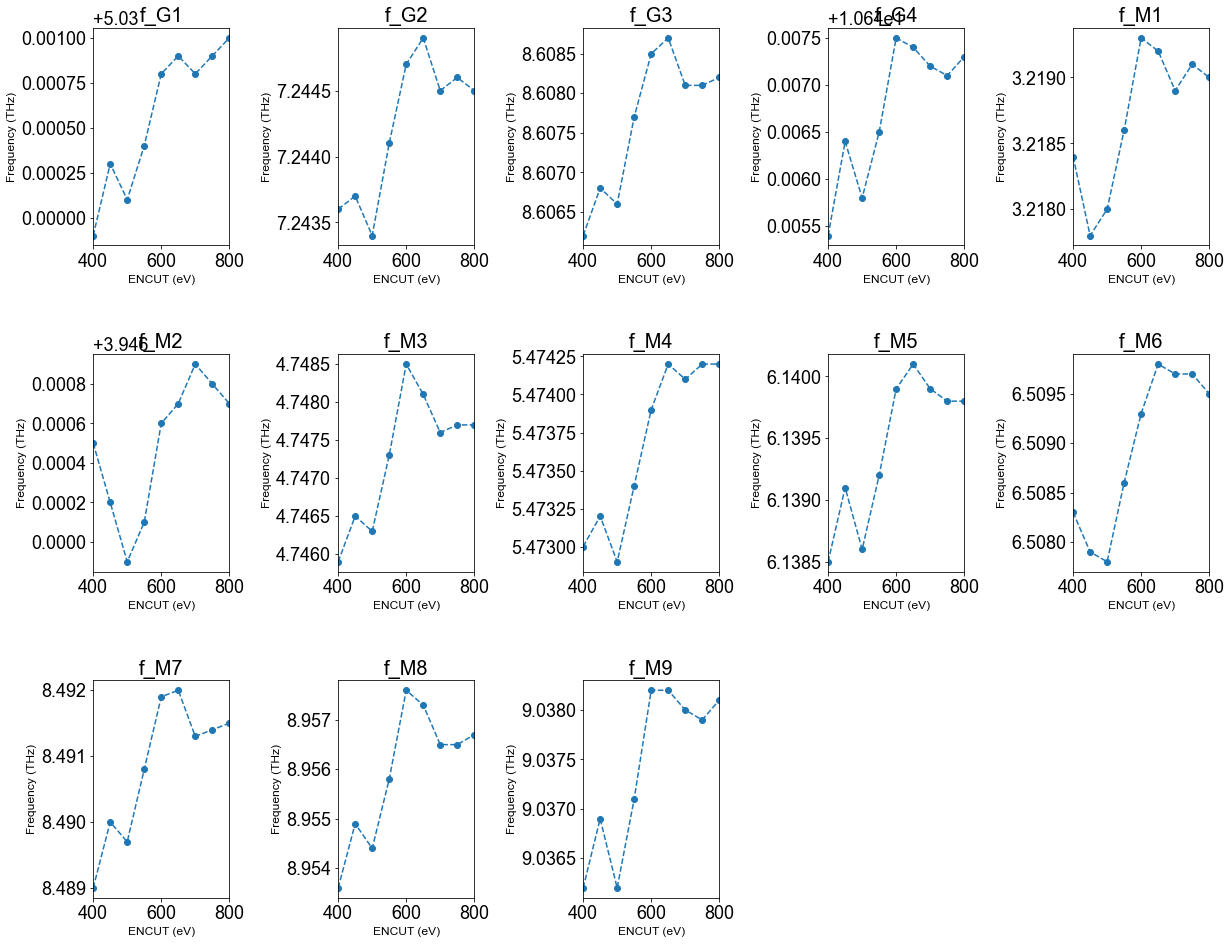

In [11]:
fig = plt.figure(figsize=(20,16))
nrows = 3
ncols = 5

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.8)

icount = 0
for irow in range(nrows):
    for icol in range(ncols):
        if icount >= 13:
            break
        ax = plt.subplot(gs[irow, icol])
        
        icount +=1
        

        ax.plot(frequencies[:,0], frequencies[:,icount], linestyle='--', marker='o')
        ax.set_title(headers[icount+3], fontsize=20)
        ax.set_xlim(400, 800)
        ax.set_xlabel('ENCUT (eV)', fontsize=12)
        ax.set_ylabel('Frequency (THz)', fontsize=12)

plt.show()

In [12]:
supercells = ['221/convergence_check', '661', '881']
supercell_labels = ['221', '661', '881']

data = [['Supercell (SC) size', 
        '# atoms in SC', 
        'ENCUT',
        'k mesh style', 'k mesh', 'k mesh shift',
        'Core hours',
        'magnitude of\ndisplacement (Ang.)']]

dispmag = 0.01

for i, sc in enumerate(supercells):
    core_hours = 0.0
    
    for idisp in range(9):
        outcar = Outcar('VASP/3.Harmonic/%s/OUTCAR.disp%d.450' % (sc, idisp+1))
        core_hours += float(outcar.run_stats['cores']) * float(outcar.run_stats['Elapsed time (sec)'])/3600

    vasprun = Vasprun('VASP/3.Harmonic/%s/vasprun_disp1_ENCUT450.xml' % sc)
    
    vasprun_dict = vasprun.as_dict()
    data.append([supercell_labels[i],
                 vasprun_dict['nsites'],
                 vasprun_dict['input']['incar']['ENCUT'],
                 vasprun_dict['input']['kpoints']['generation_style'],
                 str(vasprun_dict['input']['kpoints']['kpoints'][0]),
                 str(vasprun_dict['input']['kpoints']['shift']),
                 core_hours, dispmag])
    
summary_phband_settings = pd.DataFrame(data[1:], columns=data[0])
phband_data = []

header=['q']
for i in range(1, 10):
    header.append('f%d' %i)
pathes = ['G-M', 'G-K-M']

ranges = [[0, 101], [101, 303]]
labels = [['G', 'M'], ['G', 'K', 'M']]
tickvals = [[0.000000, 0.587033],  [0.587033, 1.264880, 1.603803]]

kayser_to_THz = 0.0299792458

for i, sc in enumerate(supercells):
    
    phband_data_now = []
    scname = supercell_labels[i]
    phband = np.loadtxt('VASP/3.Harmonic/%s/supercell%s_0.01_450.bands' % (sc, scname))
    nbands = len(phband[0,:]) - 1

    for j, path in enumerate(pathes):
        
        pd_tmp = pd.DataFrame()
        pd_tmp.attrs['SC'] = supercell_labels[i]
        nrows = ranges[j][1]-ranges[j][0]
        data = np.zeros((nrows, 10))
        data[:,0] = (phband[ranges[j][0]:ranges[j][1],0]-phband[ranges[j][0],0])
        data[:,0] /= data[-1,0]
        data[:,1:] = phband[ranges[j][0]:ranges[j][1],1:10]
        data[:,1:] *= kayser_to_THz
        
        pd_tmp['q (normalized)'] = data[:,0]
        for k in range(1, 10):
            pd_tmp['f%d' % k] = data[:,k]
        pd_tmp.attrs['line'] = path
        phband_data_now.append(pd_tmp)
    
    phband_data.append(phband_data_now)


## 3.2 Harmonic - convergence of dispersion

To examine the convergence of phonon dispersion curves, we have performed phonon calculations using various supercells and k points as summarized below:

In [13]:
summary_phband_settings

,Supercell (SC) size,# atoms in SC,ENCUT,k mesh style,k mesh,k mesh shift,Core hours,magnitude of\ndisplacement (Ang.)
0,221,12,450.0,Gamma,"[6, 6, 1]","[0.0, 0.0, 0.0]",10.561600,0.01
1,661,108,450.0,Gamma,"[2, 2, 1]","[0.0, 0.0, 0.0]",278.402240,0.01
2,881,192,450.0,Gamma,"[2, 2, 1]","[0.0, 0.0, 0.0]",1476.334613,0.01


The results are plotted in the **figure below.**

The difference between 6x6x1 and 8x8x1 results is very small. When we did not include the nonanalytic correction, a small imaginary frequency pocket appeared near the gamma point for the ZA mode when 6x6x1 cell was used. This imaginary pocket can be removed by considering the nonanalytic correction or by using a larger 8x8x1 supercell (even without nonanalytic correction).


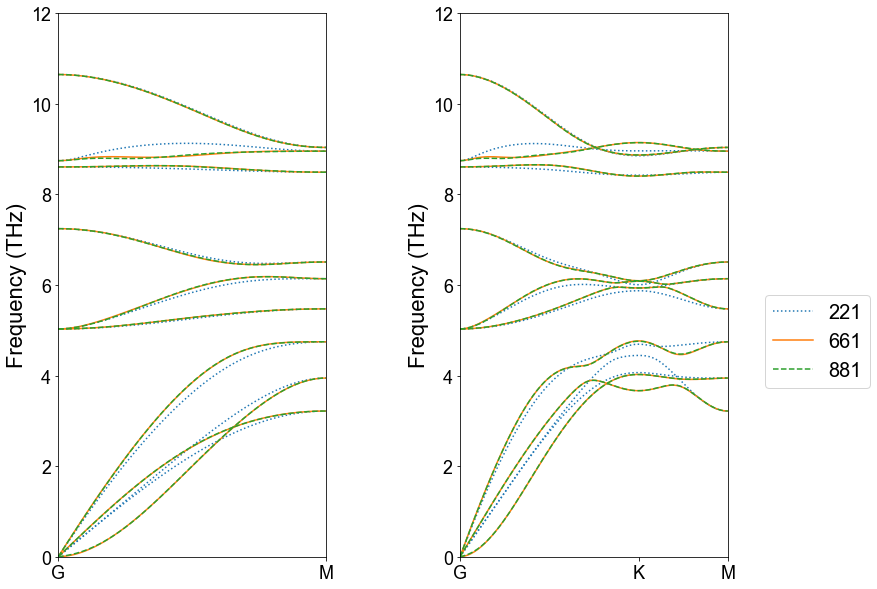

In [14]:
fig = plt.figure(figsize=(12,10))
nrows = 1
ncols = 2

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

cl = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
ls = [':', '-', '--']

for iax, ra in enumerate(ranges):
    ax = plt.subplot(gs[iax])

    for i, sc in enumerate(supercells):
        scname = supercell_labels[i]
        phband2 = phband_data[i][iax]
   
        ax.plot(phband2['q (normalized)'], phband2['f1'],
                linestyle=ls[i%3],
                marker='None',
                color=cl[i%7], 
                label=scname)

        for ib in range(1,9):
            ax.plot(phband2['q (normalized)'], phband2['f%d' % (ib + 1)],
                    linestyle=ls[i%3],
                    marker='None',
                    color=cl[i%7]) 

        ax.set_ylim(0, 12)
        xmin = tickvals[iax][0]
        xmax = tickvals[iax][-1]
        tickvals[iax][:]= (np.array(tickvals[iax][:])-xmin)/(xmax-xmin)
        ax.set_xlim(tickvals[iax][0], tickvals[iax][-1])
        ax.set_xticklabels(labels[iax])
        ax.set_xticks(tickvals[iax])
        ax.set_ylabel('Frequency (THz)')
    if iax == 1:
        ax.legend(fontsize=20, bbox_to_anchor=(1.1, 0.5))

plt.savefig('PhononBandStructure.pdf', dpi=300, bbox_inches='tight')        
plt.show()

In [15]:
import glob


def get_kappa_from_file(fname, temperature):
    retval = None
    with open(fname, 'r') as f:
        for line in f.readlines():
            if str(temperature) in line:
                if float(line.strip().split()[0]) == temperature:
                    retval = float(line.strip().split()[1])
                    break
    return retval

def get_num_displacements(fname):
    retval = None
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "Number of disp. patterns for   ANHARM3" in line:
                retval = int(line.strip().split(':')[1])
                break
    return retval


def get_num_irred_ifc3(fname):
    retval = None
    
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "Number of free  ANHARM3 FCs" in line:
                retval = int(line.strip().split(':')[1])
                break
    return retval


def get_nodehour_vasp(dirname):
    outcars = glob.glob("%s/*.OUTCAR" % dirname)
    
    retval = []
    
    nodehours = 0.0
    ncores_per_node = 48
    
    for outcar in outcars:
        obj = Outcar(outcar).as_dict()
        retval.append([obj['run_stats']['cores'],
                       obj['run_stats']['Total CPU time used (sec)'],
                       obj['run_stats']['Elapsed time (sec)']])
        
        nodehours += (int(obj['run_stats']['cores']) // ncores_per_node) \
                     * obj['run_stats']['Elapsed time (sec)']
        
    return nodehours / float(3600), retval


def get_nodehour_vasp2(dirname, regex):
    outcars = glob.glob("%s/%s" % (dirname, regex))
    
    retval = []
    
    nodehours = 0.0
    ncores_per_node = 48
    
    for outcar in outcars:
        obj = Outcar(outcar).as_dict()
        retval.append([obj['run_stats']['cores'],
                       obj['run_stats']['Total CPU time used (sec)'],
                       obj['run_stats']['Elapsed time (sec)']])
        
        nodehours += (int(obj['run_stats']['cores']) // ncores_per_node) \
                     * obj['run_stats']['Elapsed time (sec)']
        
    return nodehours / float(3600), retval

def get_corehours_vasp(outcar):

    corehours = 0.0
    
    obj = Outcar(outcar).as_dict()
    corehours = float(obj['run_stats']['cores']) * obj['run_stats']['Elapsed time (sec)'] / 3600.0
        
    return corehours


#sheet = wb.create_sheet(title='4.Anharmonic (VASP, conv. check)')

temperature = 300
# Scaling factor computed from the layer thickness
kappa_scale = 2.835429956036666

kappa_661 = []
ndisp_661 = []
nifc3_661 = []

nnlist = np.arange(1, 16, 1)

nodehour_vasp_661 = []

kappa_all = pd.DataFrame()

rcinfo1 = np.loadtxt('VASP/4.Anharmonic/661/nninfo2.txt', usecols=[1,])
nodehour = 0.0

kappa_all_list = []


sc_size_ifc2 = '881'
sc_size_ifc3 = '661'
kmesh = 60
qmesh = '60 60 1'
ntraining = 200
nodehour, _ = get_nodehour_vasp('VASP/4.Anharmonic/661/random')
corehour = 48 * nodehour

for i, nn in enumerate(nnlist[:16]):
    fname1 = 'VASP/4.Anharmonic/661/kappa/cubic_%dnn_ndata%d_ols_kmesh%d.kl' % (nn, ntraining, kmesh)
    fname3 = 'VASP/4.Anharmonic/661/%dnn/ALM0.log' % nn
    fname4 = 'VASP/4.Anharmonic/222conv/%dnn/ALM1.log' % nn
    fname5 = 'VASP/4.Anharmonic/222conv/%dnn/ALM2.log' % nn
    kappa_tmp1 = get_kappa_from_file(fname1, temperature) * kappa_scale
    ndisp = get_num_displacements(fname3)
    nifc3_tmp1 = get_num_irred_ifc3(fname3)

    rcval = rcinfo1[i]
    
    kappa_all_list.append([sc_size_ifc2, 
                           sc_size_ifc3, 
                           rcval,
                           nn,
                           ndisp,
                           nifc3_tmp1,
                           kappa_tmp1,
                           qmesh,
                           corehour])


kappa_all = pd.DataFrame(kappa_all_list, 
                         columns=['SC size IFC2', 'SC size IFC3', 
                                  'Cutoff radius for IFC3 (bohr)',
                                  'nn shell',
                                  '# disp. patterns.',
                                  '# irred. IFC3', 
                                  'kappa_{RTA,pure} (W/mK)',
                                  'qmesh',
                                  'Core hours (vasp)']).sort_values(by=['SC size IFC2', 
                                                                        'SC size IFC3'])

# Add node hour information of kappa part to the dataframe
time_661 = np.loadtxt('VASP/4.Anharmonic/661/summary_kappa.dat', usecols=[0, 4, 5])

corehour_anphon_661 = time_661[:,1] * time_661[:,2] / 3600.0

kappa_all['Core hours (kappa)'] = corehour_anphon_661

# Sort by mirror image convention after adding the node hour data
#kappa_all = kappa_all.sort_values(by=['Mirror image convention', 'SC size IFC2', 'SC size IFC3'])

## 4.1 Anharmonic - convergence w.r.t. cutoff radius and supercell size

The result of the convergence check with respect to the cutoff radius for the third-order IFC is shown in the table and figures below.

The force constants are calculated with the following methods:

- Random displacements of all atoms with magnitude of 0.03 Ang. **The number of training snapshots is fixed to 200 irrespective of the cutoff radius for IFC3.**
- Full space group symmetry considered
- Impose ASR as constraints
- Estimate third-order IFCs by ordinary least squares
- **When fitting the third-order IFCs, the second-order IFCs are fixed to the values obtained in the step 3.**

The thermal conductivity calculations are performed with the following conditions:

- 60x60x1 q points
- Use space group symmetry for reducing sampling q points and triplets (q, q', q'')
- Tetrahedron method (`ISMEAR = -1`) for delta function evaluation (It is indeed a triangle method for 2D.)
- Atomic mass : 97.905404 au (Mo), 79.916522 au (Se)
- RTA
- no ph-iso scattering, no ph-boundary effects
- Phonon group velocity is evaluated as $\boldsymbol{v}_{\boldsymbol{q}j} \approx (\omega_{\boldsymbol{q}+\Delta\boldsymbol{q}j} - \omega_{\boldsymbol{q}-\Delta\boldsymbol{q}j})/2\Delta\boldsymbol{q}$ where $\Delta\boldsymbol{q}$ is a small value (~0.001).
- Nonanalytic correction with Ewald method.
- **The dielectric tensor of monolayer MoSe2 is estimated using the method in https://www.nature.com/articles/s41699-018-0050-x**
- **The Born effective charges of monolayer MoSe2 are estimated by fitting the values computed with various vacuum spacing with a polynomial function**



In [16]:
kappa_all

,SC size IFC2,SC size IFC3,Cutoff radius for IFC3 (bohr),nn shell,# disp. patterns.,# irred. IFC3,"kappa_{RTA,pure} (W/mK)",qmesh,Core hours (vasp),Core hours (kappa)
0,881,661,4.75713,1,34,24,258.861145,60 60 1,11447.614347,1.280000
1,881,661,6.17955,2,121,102,138.237985,60 60 1,11447.614347,1.280000
2,881,661,6.29329,3,121,113,154.008646,60 60 1,11447.614347,1.333333
3,881,661,7.79854,4,147,194,110.964268,60 60 1,11447.614347,1.386667
4,881,661,8.82000,5,192,308,108.132240,60 60 1,11447.614347,1.440000
5,881,661,9.95008,6,288,563,71.519184,60 60 1,11447.614347,1.706667
6,881,661,10.70330,7,406,814,70.806357,60 60 1,11447.614347,2.133333
7,881,661,12.35910,8,502,1095,67.235983,60 60 1,11447.614347,2.773333
8,881,661,12.41640,9,522,1346,64.333921,60 60 1,11447.614347,2.826667
9,881,661,13.24300,10,558,1871,64.482781,60 60 1,11447.614347,3.680000


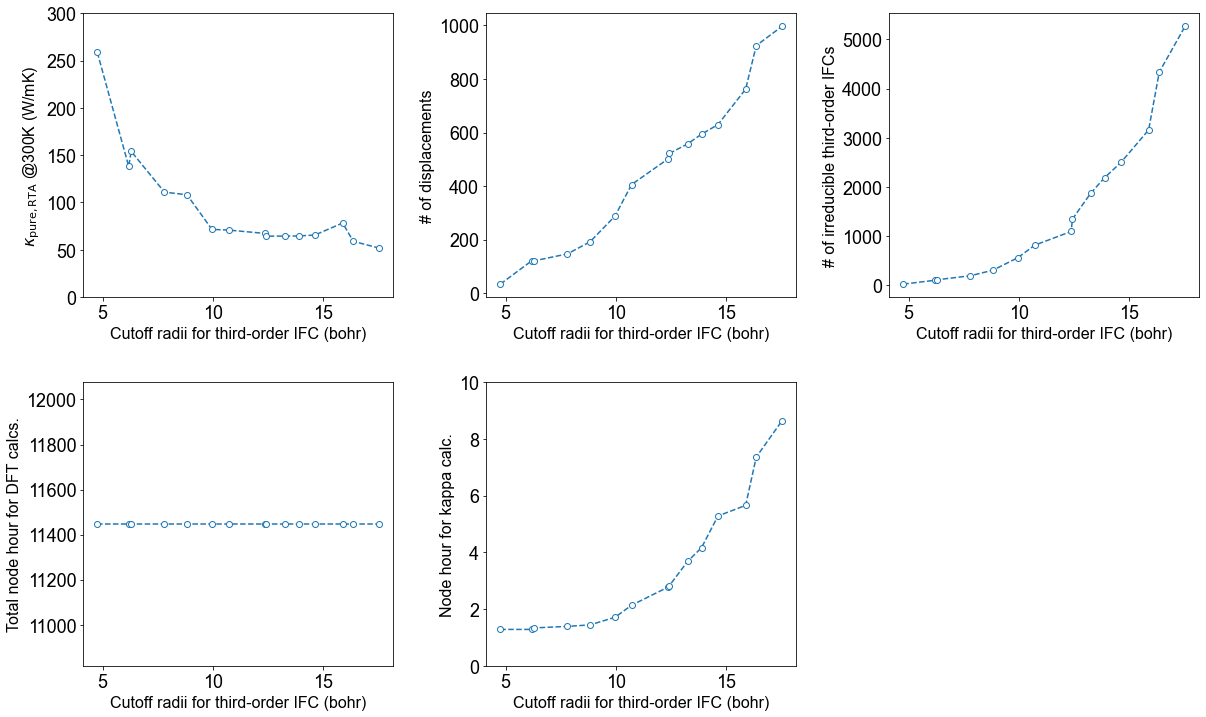

In [17]:
# 4. Anharmonic
# convergence w.r.t. cutoff radius
                             
# Plot data

fig = plt.figure(figsize=(20,12))
nrows = 2
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3, wspace=0.3)

ax = plt.subplot(gs[0,0])
ax.plot(kappa_all['Cutoff radius for IFC3 (bohr)'], kappa_all['kappa_{RTA,pure} (W/mK)'], marker='o', mfc='white', linestyle='--')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_ylim(0,300)

ax = plt.subplot(gs[0,1])
ax.plot(kappa_all['Cutoff radius for IFC3 (bohr)'], kappa_all['# disp. patterns.'], marker='o', mfc='white', linestyle='--')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("# of displacements", fontsize=16)
#ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[0,2])
ax.plot(kappa_all['Cutoff radius for IFC3 (bohr)'], kappa_all['# irred. IFC3'], marker='o', mfc='white', linestyle='--', label='AH 222conv : MIC=0')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("# of irreducible third-order IFCs", fontsize=16)
#ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[1,0])
#print(int(time_222conv_1[:,0]-1))
ax.plot(kappa_all['Cutoff radius for IFC3 (bohr)'], kappa_all['Core hours (vasp)'], marker='o', mfc='white', linestyle='--', label='AH 222conv')
ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("Total node hour for DFT calcs.", fontsize=16)
#ax.legend(loc='best', fontsize=14)


ax = plt.subplot(gs[1,1])
ax.plot(kappa_all['Cutoff radius for IFC3 (bohr)'], kappa_all['Core hours (kappa)'],marker='o', mfc='white', linestyle='--', label='HA 222conv + AH 222conv : MIC=0')

ax.set_xlabel("Cutoff radii for third-order IFC (bohr)", fontsize=16)
ax.set_ylabel("Node hour for kappa calc.", fontsize=16)
ax.set_ylim(0, 10)
#ax.legend(loc='best', fontsize=12)

plt.savefig('kappa_convergence_cutoff_and_supercellsize.pdf', bbox_inches='tight')
plt.show()

In [18]:
temperature = 300
kappa_list = []
qlist = np.arange(20, 200, 20)

kappa_conv_kmesh = pd.DataFrame()
kappa_scale = 2.835429956036666


for q in qlist:
    fname = 'VASP/4.Anharmonic/661/kappa/cubic_9nn_ndata200_ols_kmesh%d.kl' % q
    kappa_list.append(get_kappa_from_file(fname, temperature)*kappa_scale)

run_time = np.loadtxt('VASP/4.Anharmonic/661/kappa/elapsed_time.dat')

kappa_conv_kmesh['# q points along each axis'] = qlist
kappa_conv_kmesh['kappa_{RTA,pure} (W/mK)'] = kappa_list
kappa_conv_kmesh['Core hours (kappa)'] = run_time[:,2]*run_time[:,1]/ 3600.0

## 4.2 Anharmonic - convergence w.r.t. q mesh

The convergence of $\kappa_{L}$ with respect to the q point density was examined using the following computational conditions:

- `881` supercell for second-order IFCs, `661` for third-order IFCs
- Atomic mass : 97.905404 au (Mo), 79.916522 au (Se)
- $r_c = 12.43$ bohr for third-order IFCs
- Increase q mesh from 20x20x1 to 180x180x1
- RTA
- No isotope scattering

The results below shows that $\kappa_{L}$ keeps increasing with increasing $N_q$. </br>
Not sure if $\kappa_{L}$ converges in the $N_q\longrightarrow \infty$ limit. </br>
**We will use $N_q$ = 100 in the production run**.

In [19]:
kappa_conv_kmesh

,# q points along each axis,"kappa_{RTA,pure} (W/mK)",Core hours (kappa)
0,20,63.029056,0.320000
1,40,63.896414,0.906667
2,60,64.333921,2.773333
3,80,64.747894,6.880000
4,100,65.050151,14.346667
5,120,65.317532,26.080000
6,140,65.521683,42.773333
7,160,65.758441,66.986667
8,180,65.932536,99.093333


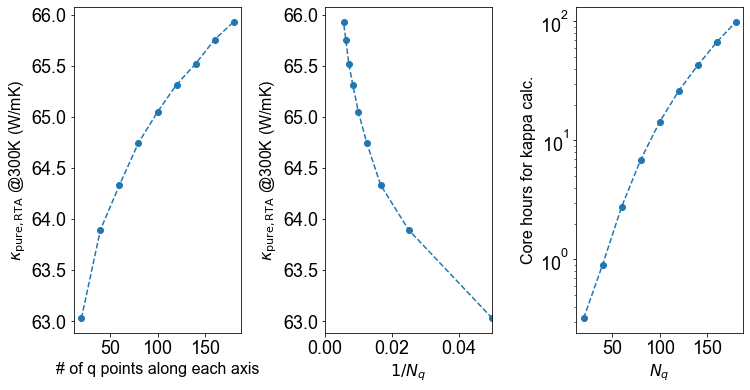

In [20]:
fig = plt.figure(figsize=(12,6))
nrows = 1
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.5, wspace=0.5)

ax = plt.subplot(gs[0])

ax.plot(kappa_conv_kmesh['# q points along each axis'], 
        kappa_conv_kmesh['kappa_{RTA,pure} (W/mK)'], 
        marker='o', linestyle='--', label='3nn')
ax.set_xlabel('# of q points along each axis', fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)

ax = plt.subplot(gs[1])

ax.plot(1.0/kappa_conv_kmesh['# q points along each axis'], 
        kappa_conv_kmesh['kappa_{RTA,pure} (W/mK)'], marker='o', linestyle='--', label='3nn')
ax.set_xlabel('$1/N_q$', fontsize=16)
ax.set_ylabel("$\kappa_{\mathrm{pure,RTA}}$ @300K (W/mK)", fontsize=16)
ax.set_xlim(0,0.05)

ax = plt.subplot(gs[2])
ax.plot(kappa_conv_kmesh['# q points along each axis'], 
        kappa_conv_kmesh['Core hours (kappa)'], marker='o', linestyle='--', label='3nn')
ax.set_xlabel('$N_q$', fontsize=16)
ax.set_ylabel("Core hours for kappa calc.", fontsize=16)
ax.set_yscale('log')
#ax.set_xlim(0,0.1)


## 4. Anharmonic - production run

After checking the convergence of kappa w.r.t. various parameters, I have chosen the following set of parameters for the production calculation.

- Lattice constant (Ang.) : 3.27
- C-axis length (Ang.) : 18.35
- Se-Se distance (Ang.) : 3.33
- ENCUT = 450
- SC for IFC2: `881`
- SC for IFC3: `661`
- Cutoff radius for IFC3 (bohr): 12.43 (includes up to 9NN shells)
- 100x100x1 q points
- tetrahedron method for delta function
- Mass of Mo : 95.9487 au for $\kappa_{nat}$, 97.905404 au for $\kappa_{pure}$
- Mass of Se : 78.9596 au for $\kappa_{nat}$, 79.916522 au for $\kappa_{pure}$
- isotope factor of Mo: 5.96749e-04 for $\kappa_{nat}$, 0 for $\kappa_{pure}$ 
- isotope factor of Se: 4.62933e-04 for $\kappa_{nat}$, 0 for $\kappa_{pure}$ 
- temperature step: 25 K 

The results of the production calculation are shown in the following tables/figures.

In [21]:
#load data of production run

kappa_scale = 2.835429956036666

kl_pure = np.loadtxt('VASP/4.Anharmonic/661/kappa/cubic_9nn_ndata200_ols_kmesh100.kl', usecols=[0, 1])
kl_nat_iso = np.loadtxt('VASP/4.Anharmonic/661/kappa/cubic_9nn_ndata200_ols_kmesh100_iso.kl', usecols=[0, 1])

target_temperatures = np.concatenate((np.arange(50, 300, 25),
                                      np.arange(300, 1001, 100)))

kl_pure_save = []
kl_nat_iso_save = []
for i in range(len(kl_pure)):
    if kl_pure[i,0] in target_temperatures:
        kl_pure_save.append(kl_pure[i,1])

for i in range(len(kl_nat_iso)):
    if kl_nat_iso[i,0] in target_temperatures:
        kl_nat_iso_save.append(kl_nat_iso[i,1])
        
kl_production = pd.DataFrame()
kl_production['temperature (K)'] = target_temperatures
kl_production['kappa_{nat, RTA} (W/mK)'] = np.array(kl_nat_iso_save) * kappa_scale
kl_production['kappa_{pure, RTA} (W/mK)'] = np.array(kl_pure_save) * kappa_scale

kl_pure_accum = pd.read_table('VASP/4.Anharmonic/661/kappa/pure_cubic_9nn_k100_cumulative.dat', comment='#', 
                              header=None, names=['mfp (nm)', 'cumulative kappa (W/mK)'], 
                              delim_whitespace=True, usecols=[0, 1])

kl_nat_accum = pd.read_table('VASP/4.Anharmonic/661/kappa/nat_iso_cubic_9nn_k100_cumulative.dat', comment='#', 
                             header=None, names=['mfp (nm)', 'cumulative kappa (W/mK)'], 
                             delim_whitespace=True, usecols=[0, 1])
kl_pure_spec = pd.read_table('VASP/4.Anharmonic/661/kappa/cubic_9nn_ndata200_ols_kmesh100.kl_spec', comment='#',
                             header=None, names=['temperature (K)', 'omega (cm^-1)', 'kappa spec'],
                             delim_whitespace=True, usecols=[0, 1, 2])
kl_nat_spec = pd.read_table('VASP/4.Anharmonic/661/kappa/cubic_9nn_ndata200_ols_kmesh100_iso.kl_spec', comment='#',
                             header=None, names=['temperature (K)', 'omega (cm^-1)', 'kappa spec'],
                             delim_whitespace=True, usecols=[0, 1, 2])

kl_pure_spec = kl_pure_spec[kl_pure_spec['temperature (K)'] == 300]
kl_nat_spec = kl_nat_spec[kl_nat_spec['temperature (K)'] == 300]


kl_pure_accum['cumulative kappa (W/mK)'] *= kappa_scale
kl_nat_accum['cumulative kappa (W/mK)'] *= kappa_scale

#convert unit of kl_spec

kl_pure_spec['omega (cm^-1)'] *= kayser_to_THz
kl_pure_spec['kappa spec'] *= kappa_scale / kayser_to_THz
kl_pure_spec.rename(columns={'omega (cm^-1)': 'frequency (THz)', 'kappa spec' : 'kappa spec (W/mK/THz)'}, inplace=True)
kl_pure_spec['cumulative kappa (W/mK)'] = kl_pure_spec['kappa spec (W/mK/THz)'].cumsum()*kayser_to_THz

kl_nat_spec['omega (cm^-1)'] *= kayser_to_THz
kl_nat_spec['kappa spec'] *= kappa_scale / kayser_to_THz
kl_nat_spec.rename(columns={'omega (cm^-1)': 'frequency (THz)', 'kappa spec' : 'kappa spec (W/mK/THz)'}, inplace=True)
kl_nat_spec['cumulative kappa (W/mK)'] = kl_nat_spec['kappa spec (W/mK/THz)'].cumsum()*kayser_to_THz



kl_production

,temperature (K),"kappa_{nat, RTA} (W/mK)","kappa_{pure, RTA} (W/mK)"
0,50,557.704121,721.181118
1,75,319.412319,365.449777
2,100,218.455417,239.437883
3,125,165.706213,177.752537
4,150,133.762542,141.624623
5,175,112.399846,117.952752
6,200,97.093912,101.226834
7,225,85.568456,88.760583
8,250,76.560578,79.094886
9,275,69.315771,71.370891


In [22]:
mode_contribution_nat = pd.read_table('VASP/4.Anharmonic/661/kappa/tau300K_q100_nat.dat', comment='#',
                                      header=None, 
                                      names=['k index (irred.)', 'branch index', 'f (cm^-1)', 'lifetime (ps)', 'mfp (nm)', 
                                             'multiplicity', 'modal kappa (W/mK)'],
                                      delim_whitespace=True, usecols=[0, 1, 2, 3, 5, 6, 7])

mode_contribution_nat_iso = pd.read_table('VASP/4.Anharmonic/661/kappa/tau300K_q100_nat_iso.dat', comment='#',
                                          header=None, 
                                          names=['k index (irred.)', 'branch index', 'f (cm^-1)', 'lifetime (ps)', 'mfp (nm)', 
                                                 'multiplicity', 'modal kappa (W/mK)'],
                                          delim_whitespace=True, usecols=[0, 1, 2, 3, 5, 6, 7])

mode_contribution_nat['f (cm^-1)'] *= kayser_to_THz
mode_contribution_nat_iso['f (cm^-1)'] *= kayser_to_THz

mode_contribution_nat.rename(columns={'f (cm^-1)' : 'f (THz)'}, inplace=True)
mode_contribution_nat_iso.rename(columns={'f (cm^-1)' : 'f (THz)'}, inplace=True)

mode_contribution_nat['modal kappa (W/mK)'] *= kappa_scale
mode_contribution_nat_iso['modal kappa (W/mK)'] *= kappa_scale


scattering_rates = mode_contribution_nat.iloc[:,0:3]
scattering_rates['1/tau_3ph (THz)'] = 1.0 / mode_contribution_nat['lifetime (ps)']
scattering_rates['1/tau_iso (THz)'] = 1.0 / mode_contribution_nat_iso['lifetime (ps)'] - 1.0 / mode_contribution_nat['lifetime (ps)']
scattering_rates.at[0, '1/tau_3ph (THz)'] = 0
scattering_rates.at[1, '1/tau_3ph (THz)'] = 0
scattering_rates.at[2, '1/tau_3ph (THz)'] = 0
scattering_rates.at[0, '1/tau_iso (THz)'] = 0
scattering_rates.at[1, '1/tau_iso (THz)'] = 0
scattering_rates.at[2, '1/tau_iso (THz)'] = 0

In [23]:
mode_contribution_nat_iso

,k index (irred.),branch index,f (THz),lifetime (ps),mfp (nm),multiplicity,modal kappa (W/mK)
0,1,1,3.289832e-12,0.00000,0.000000,1,0.000000e+00
1,1,2,3.289832e-12,0.00000,0.000000,1,0.000000e+00
2,1,3,3.289832e-12,0.00000,0.000000,1,0.000000e+00
3,1,4,5.030757e+00,7.35286,0.000000,1,0.000000e+00
4,1,5,5.030757e+00,7.35286,0.000000,1,0.000000e+00
...,...,...,...,...,...,...,...
7951,884,5,6.084408e+00,6.24462,0.251167,6,1.076216e-07
7952,884,6,6.096130e+00,4.83518,0.259852,6,1.487271e-07
7953,884,7,8.406720e+00,5.44486,0.092557,6,1.562546e-08
7954,884,8,8.869660e+00,3.31397,0.075109,6,1.662863e-08


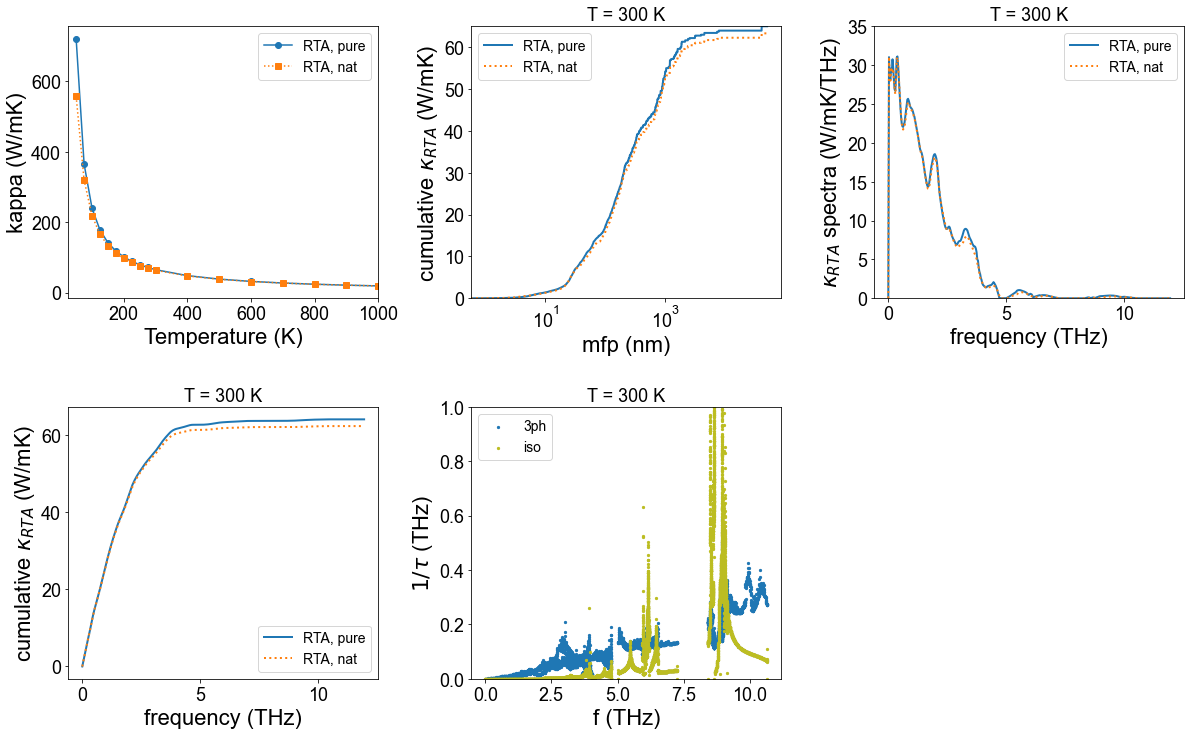

In [24]:
# Plot data

fig = plt.figure(figsize=(20,12))
nrows = 2
ncols = 3

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.4, wspace=0.3)

ax = plt.subplot(gs[0])
ax.plot(kl_production['temperature (K)'], kl_production['kappa_{pure, RTA} (W/mK)'], linestyle='-', marker='o', label='RTA, pure')
ax.plot(kl_production['temperature (K)'], kl_production['kappa_{nat, RTA} (W/mK)'], linestyle=':', marker='s', label='RTA, nat')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('kappa (W/mK)')
#ax.set_xscale('log')
ax.set_xlim(25,1000)
#ax.set_ylim(10,1e+5)
ax.legend(loc='best', fontsize=14)

ax = plt.subplot(gs[1])
kl_pure_accum.plot(x=0, y=1, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, label="RTA, pure")
kl_nat_accum.plot(x=0, y=1, ax=ax, ylabel=r'cumulative $\kappa_{RTA}$ (W/mK)', linewidth=2.0, linestyle=':', label="RTA, nat")
ax.set_ylim(0, 65)
ax.legend(loc='best', fontsize=14)
ax.set_xscale('log')
ax.set_title('T = 300 K', fontsize=18)


ax = plt.subplot(gs[2])
kl_pure_spec.plot(x=1, y=2, ax=ax, linewidth=2.0, label="RTA, pure")
kl_nat_spec.plot(x=1, y=2, ax=ax, ylabel=r'$\kappa_{RTA}$ spectra (W/mK/THz)', linewidth=2.0, linestyle=":", label="RTA, nat")
#ax.set_xlim(0, 9)
ax.set_ylim(0, 35)
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)


ax = plt.subplot(gs[3])
ax.plot(kl_pure_spec['frequency (THz)'], kl_pure_spec['cumulative kappa (W/mK)'], linewidth=2.0, linestyle='-', label="RTA, pure")
ax.plot(kl_nat_spec['frequency (THz)'], kl_nat_spec['cumulative kappa (W/mK)'], linewidth=2.0, linestyle=':', label="RTA, nat")
#kl_pure_spec.plot(x=1, y=2, ax=ax, linewidth=2.0, label="RTA, pure")
#kl_nat_spec.plot(x=1, y=2, ax=ax, ylabel=r'$\kappa_{RTA}$ spectra (W/mK/THz)', linewidth=2.0, linestyle=":", label="RTA, nat")
#ax.set_xlim(0, 9)
#ax.set_ylim(0, 65)
ax.set_xlabel('frequency (THz)')
ax.set_ylabel(r'cumulative $\kappa_{RTA}$ (W/mK)')
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)


ax = plt.subplot(gs[4])
scattering_rates.plot(x=2, y=3, ax=ax, kind='scatter', marker='.', label='3ph')
scattering_rates.plot(x=2, y=4, ax=ax, kind='scatter', marker='.', label='iso', color='C8', ylabel=r'$1/\tau$ (THz)')
ax.legend(loc='best', fontsize=14)
ax.set_title('T = 300 K', fontsize=18)
#ax.set_xlim(0, 12)
ax.set_ylim(0, 1.0)

plt.savefig('production_kappa.pdf', bbox_inches='tight')
plt.show()

In [25]:
# Write all data to files


# Electronic band structures

for i in range(2):

    filename = 'upload/outputs/band_%s.txt' % bs1[i].attrs['line']
    with open(filename, 'w') as f:
        f.write("# Efermi (eV) : %f\n" % bs1[i].attrs['efermi'])
        f.write("# %s\n" % bs1[i].attrs['SCF'])

    bs1[i].to_csv(filename, index=None, sep=' ', mode='a', float_format="%.5f")

    

# Phonon band structures

lines = ['G-M', 'G-K-M']

for i in range(2):
    
    filename = 'upload/outputs/phband_%s.txt' % lines[i]
    with open(filename, 'w') as f:
        f.write("# 8x8x1 supercell\n")

    phband_data[2][i].to_csv(filename, index=None, sep=' ', mode='a', float_format="%.5f")

    
# Thermal conductivities

filename = 'upload/outputs/kappa_temperature_dependence.txt'
with open(filename, 'w') as f:
    f.write("# 8x8x1 supercell for harmonic, 6x6x1 supercell for cubic ifcs\n")
    f.write("# 100x100x1 k points for kappa\n")
    f.write("# cubic ifcs up to 9NN shell trained with ordinary least squares by 200 configurations.\n")

kl_production.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


filename = 'upload/outputs/kappa_300K_cumulative_freq.txt'
with open(filename, 'w') as f:
    f.write("# 8x8x1 supercell for harmonic, 6x6x1 supercell for cubic ifcs\n")
    f.write("# 100x100x1 k points for kappa\n")
    f.write("# cubic ifcs up to 9NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")

kl_nat_spec.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


filename = 'upload/outputs/kappa_300K_cumulative_mfp.txt'
with open(filename, 'w') as f:
    f.write("# 8x8x1 supercell for harmonic, 6x6x1 supercell for cubic ifcs\n")
    f.write("# 100x100x1 k points for kappa\n")
    f.write("# cubic ifcs up to 9NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")

kl_nat_accum.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')

filename = 'upload/outputs/mfp_and_mode_contribution_300K.txt'
with open(filename, 'w') as f:
    f.write("# 8x8x1 supercell for harmonic, 6x6x1 supercell for cubic ifcs\n")
    f.write("# 100x100x1 k points for kappa\n")
    f.write("# cubic ifcs up to 9NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")
    
mode_contribution_nat_iso.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f',
                                 columns=["k index (irred.)","branch index", "f (THz)", "mfp (nm)", "multiplicity", "modal kappa (W/mK)"])

print(np.dot(mode_contribution_nat_iso['modal kappa (W/mK)'], mode_contribution_nat_iso['multiplicity']))


filename = 'upload/outputs/scattering_rates_300K.txt'
with open(filename, 'w') as f:
    f.write("# 8x8x1 supercell for harmonic, 6x6x1 supercell for cubic ifcs\n")
    f.write("# 100x100x1 k points for kappa\n")
    f.write("# cubic ifcs up to 9NN shell trained with ordinary least squares by 200 configurations.\n")
    f.write("# Temperature = 300 K\n")
    
scattering_rates.to_csv(filename, index=None, sep=' ', mode='a', float_format='%.5f')


63.35546780321118


In [26]:
# Computational times

jobs = ['Structure', 'Electrons', 'Harmonic', 'Anharmonic', 'Thermal cond.']
times_convcheck = []
times_production = []

times_convcheck.append(vasp_encut['Core Hours'].sum() + vasp_kmesh['Core Hours'].sum())

time_tmp = get_corehours_vasp('VASP/2.Electrons/OUTCAR.scf_dense') \
           + get_corehours_vasp('VASP/2.Electrons/OUTCAR.band1_dense') \
           + get_corehours_vasp('VASP/2.Electrons/OUTCAR.band2_dense')

time_tmp +=  get_corehours_vasp('VASP/2.Electrons/OUTCAR.scf') \
           + get_corehours_vasp('VASP/2.Electrons/OUTCAR.band1') \
           + get_corehours_vasp('VASP/2.Electrons/OUTCAR.band2')

times_convcheck.append(time_tmp)


time_tmp = get_nodehour_vasp2('VASP/3.Harmonic/221/convergence_check', "OUTCAR.*")[0] \
                       + get_nodehour_vasp2('VASP/3.Harmonic/661', "OUTCAR.disp*")[0] \
                       + get_nodehour_vasp2('VASP/3.Harmonic/881', "OUTCAR.disp*")[0] 
time_tmp += get_nodehour_vasp2('VASP/3.Harmonic/dielec', "OUTCAR.*")[0] \
            + get_nodehour_vasp2('VASP/3.Harmonic/dielec', "OUTCAR.vac*")[0]
times_convcheck.append(time_tmp*48)

time_tmp = kappa_all['Core hours (vasp)'][0]
times_convcheck.append(time_tmp)


time_tmp = kappa_all['Core hours (kappa)'].sum()
time_tmp += kappa_conv_kmesh['Core hours (kappa)'].sum()
times_convcheck.append(time_tmp)

times_production.append(get_corehours_vasp('VASP/1.Structure/production_run/OUTCAR.preprod'))

times_tmp =  get_corehours_vasp('VASP/2.Electrons/OUTCAR.scf') \
           + get_corehours_vasp('VASP/2.Electrons/OUTCAR.band1') \
           + get_corehours_vasp('VASP/2.Electrons/OUTCAR.band2')
times_production.append(times_tmp)


time_tmp = get_nodehour_vasp2('VASP/3.Harmonic/881', "OUTCAR.disp*")[0] 
times_production.append(time_tmp)

times_production.append( kappa_all['Core hours (vasp)'][0])
time_tmp = (192 * 269 + 384 * 164) / 3600.0
times_production.append(time_tmp)


filename = 'upload/outputs/core_hours.txt'
with open(filename, 'w') as f:

    f.write('# Summary of CPU time in units of core*hours\n')
    f.write('#         Job, time for conv. check, time for production run\n')
    for i in range(5):
        f.write("%15s %10.1f %10.1f\n" % (jobs[i], times_convcheck[i], times_production[i]))

